# **Assignment 1: Core Transformer Components from Scratch**  
**Objective**: Implement the mathematical backbone of transformers.  

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

## 1. **Positional Encoding**:  
   - Code the sinusoidal positional encoding matrix using only `torch.tensor` operations (no `nn.Module`).  
   - Prove mathematically why the dot product of positional embeddings encodes relative distances.  
   - Visualize the positional encoding matrix heatmap for sequence lengths 0–100.  

### Theory

1. **Séquence d'entrée**
Séquence de longueur L, contenant des tokens sous forme de vecteurs d'embedding de dimension d.

$$X \in \mathbb R ^{L \times d}$$

où L est la longueur de la séquence et d est la dimension des embeddings.  
   - **Note**: Utilisez `torch` pour les calculs, mais évitez les modules de haut niveau comme `nn.Embedding`.

2. **Position Encoding (PE)**
On ajoute un vecteur $PE_i$ à chaque embedding $X_i$ pour avoir une représentation enrichie. Au final la matrice devient:

$$X' = X + PE$$


3. **Formule de calcul du Positional Encoding (sinusoïdal) :**  
   L'approche la plus courante utilise des fonctions sinusoïdales de différentes fréquences :
   $$
   PE_{(i, 2k)} = \sin\left(\frac{i}{10000^{\frac{2k}{d}}}\right)
   $$
   $$
   PE_{(i, 2k+1)} = \cos\left(\frac{i}{10000^{\frac{2k}{d}}}\right)
   $$
   où :
   - $i$ est l’index du token dans la séquence (position).
   - $k$ est l’index de la dimension dans l’espace d’embedding.
   - $d$ est la dimension totale de l’embedding.

4. **Interprétation :**  
   - Les fréquences différentes permettent de capturer des relations entre tokens à différentes échelles.
   - Ces fonctions permettent d’encoder les positions tout en préservant des propriétés qui facilitent l’apprentissage, notamment en permettant au modèle d’interpréter les positions relatives de manière fluide.


### Coding the positional encoding

In [2]:
d = 512 # embeddings
seq_len = 100 # mots

In [3]:
def getPE(seq_len, d, n = 1e4):
    PE = torch.zeros((seq_len,d), dtype=torch.float32)
    denom = n
    for i in range(seq_len):
        for k in torch.arange(int(d/2)):
            PE[i,2*k] = torch.sin(i/(denom**(2*k/d)))
            PE[i,2*k+1] = torch.cos(i/(denom**(2*k/d)))
    return PE

In [4]:
PE = getPE(4,6)
print(PE)

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000]])


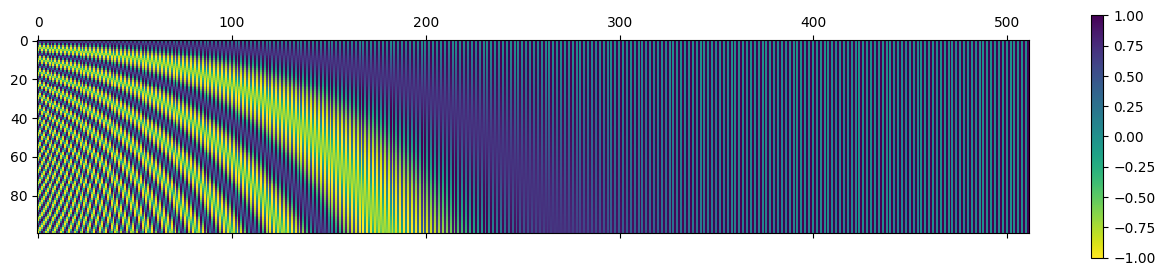

In [ ]:
# plot PE
import matplotlib.pyplot as plt
PE = getPE(100,512, n = 1e4)
cax = plt.matshow(PE, cmap='viridis_r')
plt.gcf().colorbar(cax)
plt.plot()

### Démo + Contexte
#### **1. Contexte : du Positional Encoding à l'Attention**  

On rappelle les étapes :  

1. **On ajoute le positional encoding** à l'embedding initial :  
   $$
   X' = X + PE
   $$  

2. **On calcule les matrices Query, Key et Value :**  
   $$
   Q = X' W_Q, \quad K = X' W_K, \quad V = X' W_V
   $$  

3. **On calcule l'Attention Score :**  
   $$
   \text{Attention} = \text{softmax} \left( \frac{Q K^T}{\sqrt{d_k}} \right) V
   $$  

Ainsi, le cœur du mécanisme repose sur **le produit scalaire $Q K^T$**.  

---

#### **2. Pourquoi se pose la question du produit scalaire $PE^T PE$ ?**  

Si on explicite $Q$ et $K$ en remplaçant $X' = X + PE$ :  

$$
Q = (X + PE) W_Q, \quad K = (X + PE) W_K
$$

Le score d'attention devient :  

$$
Q K^T = (X + PE) W_Q W_K^T (X + PE)^T
$$

Développons ce terme :  

$$
Q K^T = X W_Q W_K^T X^T + X W_Q W_K^T PE^T + PE W_Q W_K^T X^T + PE W_Q W_K^T PE^T
$$

Le dernier terme **$PE W_Q W_K^T PE^T$** est particulièrement intéressant. Si $W_Q W_K^T$ est bien conditionné, ce terme est **proportionnel à** :  

$$
PE PE^T
$$

Donc, pour comprendre comment l'Attention encode les distances relatives, il faut comprendre la structure du **produit scalaire entre positional encodings**. **D'où la demande de démontrer que $\langle PE(i) ,  PE(j) \rangle$ encode la distance relative $|i - j|$.**  

---

#### **3.Preuve**

Montrons que pour deux positions $i,j \in \{1,2,..d\}$,
$$
\langle PE(i) ,  PE(j) \rangle \propto |i-j|
$$

---

1. **Structure du Positional Encoding**

On utilise :  
$$
PE_{(i, 2k)} = \sin\left(\frac{i}{10000^{\frac{2k}{d}}}\right), \quad PE_{(i, 2k+1)} = \cos\left(\frac{i}{10000^{\frac{2k}{d}}}\right)
$$
pour deux positions $i$ et $j$.


2. **Expression du Produit Scalaire**

Le produit scalaire entre $PE(i)$ et $PE(j)$ est :
$$
PE(i) \cdot PE(j) = \sum_{k=0}^{d/2 - 1} \left[ \sin\left(\frac{i}{\lambda_k}\right) \sin\left(\frac{j}{\lambda_k}\right) + \cos\left(\frac{i}{\lambda_k}\right) \cos\left(\frac{j}{\lambda_k}\right) \right]
$$
où $\lambda_k = 10000^{\frac{2k}{d}}$.

Grâce à l'identité trigonométrique :
$$
\cos(A - B) = \cos A \cos B + \sin A \sin B
$$
on obtient :
$$
PE(i) \cdot PE(j) = \sum_{k=0}^{d/2 - 1} \cos\left(\frac{i - j}{\lambda_k}\right)
$$



3. **Conclusion**

Le produit scalaire entre $PE(i)$ et $PE(j)$ **ne dépend que de la différence $i - j$**, ce qui montre que les positional encodings **encodent les distances relatives**.
T



## Self-Attention

   - Implement scaled dot-product attention **without** using `torch.nn.MultiheadAttention`:  
     - Compute $Q$, $K$, $V$ matrices manually ($W_Q$, $W_K$, $W_V$ as learnable parameters).  
     - Derive the gradient of the attention weights $\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)$ w.r.t. $Q$ and $K$ (symbolic math).  
   - Compare your implementation’s output to PyTorch’s `F.scaled_dot_product_attention` (tolerance < 1e-6).  

### **Dimensionnement des matrices**

Bonne question ! Définissons **précisément** les dimensions des matrices pour bien comprendre ce qui se passe.

---

#### **1. Dimensions de $X$ et $PE$**
On suppose :  
- Une séquence de **longueur** $L$ (nombre de tokens).
- Une **dimension d’embedding** $d$ (chaque mot est un vecteur de taille $d$).  

Les matrices sont donc :  
$$
X \in \mathbb{R}^{L \times d}, \quad PE \in \mathbb{R}^{L \times d}
$$

Comme $X' = X + PE$, on a toujours $X' \in \mathbb{R}^{L \times d}$.

---

#### **2. Dimensions des matrices $Q, K, V$**
On veut que chaque token ait un vecteur Query, Key et Value de taille $d_k$ (en général $d_k = d/ h$ avec $h$ le nombre de têtes d'attention, mais restons généraux).  

On applique des transformations linéaires :  

$$
Q = X' W_Q, \quad K = X' W_K, \quad V = X' W_V
$$

avec  
$$
W_Q \in \mathbb{R}^{d \times d_k}, \quad W_K \in \mathbb{R}^{d \times d_k}, \quad W_V \in \mathbb{R}^{d \times d_v}
$$

Ce qui donne :  
$$
Q \in \mathbb{R}^{L \times d_k}, \quad K \in \mathbb{R}^{L \times d_k}, \quad V \in \mathbb{R}^{L \times d_v}
$$

> **Remarque** : Souvent, $d_k = d_v = d_h$ et dans un **multi-head attention**, on a plusieurs têtes de taille $d_k = d/h$, mais ici on considère une seule tête.

---

#### **3. Dimension de $Q K^T$**
L'Attention se base sur le produit scalaire entre **Query et Key** :  

$$
Q K^T \in \mathbb{R}^{L \times d_k} \times \mathbb{R}^{d_k \times L} = \mathbb{R}^{L \times L}
$$

Ce qui est logique : **on obtient une matrice qui encode la similarité entre chaque paire de tokens dans la séquence.**  

### Coding: Self-attention

In [47]:
h = 1 # number of attention heads
d_k = int(d/h)

In [48]:
torch.manual_seed(1)
X = torch.rand((seq_len, d))
X = X + getPE(seq_len, d)
W_Q = torch.rand((d, d_k))
W_K = torch.rand((d, d_k))
W_V = torch.rand((d, d_k))

In [49]:
Q = X @ W_Q
K = X @ W_K
V = X @ W_V

In [50]:
def attention(Q,K,V):
    d_k_func = torch.tensor(Q.shape[1])
    return F.softmax(Q@K.T/torch.sqrt(d_k_func)) @ V

In [51]:
# compare with torch

torch.allclose(attention(Q,K,V), F.scaled_dot_product_attention(Q,K,V), atol=1e-6)

/tmp/ipykernel_82385/2115172868.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(Q@K.T/torch.sqrt(d_k_func)) @ V


True

In [52]:
attention(Q,K,V).shape, F.scaled_dot_product_attention(Q,K,V).shape

/tmp/ipykernel_82385/2115172868.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(Q@K.T/torch.sqrt(d_k_func)) @ V


(torch.Size([100, 512]), torch.Size([100, 512]))

[]

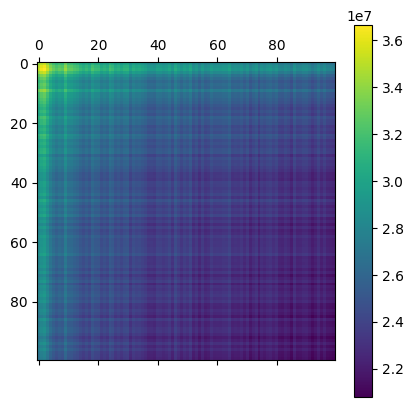

In [54]:
cax2 = plt.matshow(Q@K.T, cmap='viridis')
plt.gcf().colorbar(cax2)
plt.plot()

In [ ]:
# Making it a class

class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super(MultiheadAttention, self).__init__()

        # TODO: provide implementation

        self.embed_dim = None 
        self.num_heads = None
        self.head_dim = None
        # Assert ...

        # Create projection matrices as learnable parameters

    def foward(self): # and more params
        batch_size = None

        # Project and reshape to ???

        # Scale dot-product attention

        # Apply mask if provided

        # Apply softmax

        # Apply attention weights

        # Reshape back and prject to output dimension
        attn_output = None
        attn_weights = None 

        return attn_output, attn_weights
